# HW10: Multi Variate Local Volatility MC Models

## Preliminaries

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
import scipy.optimize as optimize

### Random Seed

In [2]:
seed=734903
rng=np.random.default_rng(seed)

### Code

#### Discount

In [3]:
class Discount:
    def __init__(self,ts,rates):
        self.ts=ts
        self.rates=rates
    def __call__(self,T):
        r=np.interp(T,self.ts,self.rates)
        return np.exp(-r*T)
 


####  Forward

In [ ]:
class Forward:
    def __init__(self,spot,discount,dividends):
        self.spot=spot
        self.discount=discount
        self.dividends=dividends
    def __call__(self,T):
        Df_r=self.discount(T)
        Df_d=self.dividends(T)
        return self.spot*Df_d/Df_r

#### SVI Volatility Surface
<a id="svi"/>

In [4]:
        

class SVI:
    def __init__(self,ref_fwd,ts,a,b,rho,m,sigma):
        self.ref_fwd=ref_fwd
        self.ts=np.insert(ts,[0],[0])
        self.as_=np.insert(a,[0],[0])
        self.bs=np.insert(b,[0],[0])
        self.rhos=np.insert(rho,[0],[rho[0]])
        self.ms=np.insert(m,[0],m[[0]])
        self.sigmas=np.insert(sigma,[0],[sigma[0]])

    def var(self,T,K):
        ref_F=self.ref_fwd(T)
        ref_k=np.log(K/ref_F)
        return self.var0(T,ref_k)
    def var0(self,T,ref_k):
        a=np.interp(T,self.ts,self.as_)
        b=np.interp(T,self.ts,self.bs)
        rho=np.interp(T,self.ts,self.rhos)
        m=np.interp(T,self.ts,self.ms)
        sigma=np.interp(T,self.ts,self.sigmas)
        return a + b*(rho*(ref_k-m)+np.sqrt((ref_k-m)**2+sigma**2))
    def dvar(self,T,K):
        ref_F=self.ref_fwd(T)
        ref_k=np.log(K/ref_F)
        a=np.interp(T,self.ts,self.as_)
        b=np.interp(T,self.ts,self.bs)
        rho=np.interp(T,self.ts,self.rhos)
        m=np.interp(T,self.ts,self.ms)
        sigma=np.interp(T,self.ts,self.sigmas)
        Delta=np.sqrt((ref_k-m)**2+sigma**2)
        w=a + b*(rho*(ref_k-m)+Delta)     
        dw_dk=b*(rho+(ref_k-m)/Delta)
        d2w_dk2=b/Delta*(1-((m-ref_k)/Delta)**2)
        return ref_k,w,dw_dk,d2w_dk2
    def local_vol(self,T,K,F,dT=1/365):
        T=np.maximum(T,1e-6)
        k=np.log(K/F)
        ref_k,w,dw_dk,d2w_dk2=self.dvar(T,K)
        w1=self.var0(T+dT,ref_k)
        dw_dt=(w1-w)/dT
        var= dw_dt/(1-k/w*dw_dk+1/4*(-1/4-1/w+(k/w)**2)*dw_dk**2+1/2*d2w_dk2)
        return np.sqrt(var)
    def __call__(self,T,K):
        "SVI Implied volatility as a funtion of expiry T (in years) and strike K"
        T=np.maximum(T,epsilon) # do not devide by zero when T=0
        return np.sqrt(self.var(T,K)/T)

#### Multi Variate  Local Volatility Process Definition

<a id="vol_process"/>

In [5]:
class MVLocalVolProcess:
    def __init__(self,fwds,vols,corr):
        self.fwds=fwds
        self.vol=vols
        self.L=np.linalg.cholesky(corr)
        self.df=np.empty(len(fwds))
    def nfactors(self):
        return len(self.fwds)
    def __call__(self,s,t,dt,dZ):
        var=np.empty((len(self.df),dZ.shape[1]))
        for i in range(self.nfactors()):
            F=self.fwds[i](t)
            self.df[i]=self.fwds[i](t+dt)/F
            var[i]=self.vol[i].local_vol(t,s[i],F)**2*dt
        dW=np.dot(self.L,dZ) # correlate
        dW=np.sqrt(var)*dW # scale by variance
        s1=s*self.df[:,np.newaxis]*np.exp(-var/2+dW)
        return s1
        

#### Monte Carlo Propagation

In [6]:
def propagate(process,s0,ts,rgen,npaths):
    nsteps=len(ts)
    nvars=len(s0)
    S=np.empty((nsteps,nvars,npaths))
    S[0]=s0[:,np.newaxis]
    nfactors=process.nfactors()
    for it,t in enumerate(ts[:-1]):
        dt=ts[it+1]-t
        dW=rgen.standard_normal((nfactors,npaths))
        S[it+1]=process(S[it],t,dt,dW)
    return S

#### Black-Scholes Option Price

#### Forward Option Price
<a id="black-scholes"/>

In [7]:
ndtr=stats.norm.cdf
epsilon=1e-6

def bs_price_fwd(isCall, K, T, F, sigma):
    """ Black's pricing formula
    
    European option  forward price as a function of
    the asset's forward.
    
    :param isCall: True for calls , False for Puts
    :type isCall: Boolean
    :param K: option strike
    :param T: option expiry in years
    :param F: forward of the options underlying asset
    :param sigma: underlying's  volatility
    :return: option's forward price
    """
    
    ds=np.maximum(epsilon,sigma*np.sqrt(T))
    var=0.5*ds*ds
    d2=(np.log(F/np.maximum(K,epsilon))-var)/ds
    d1=d2+ds
    if isCall:
        opt= F*ndtr(d1) - K*ndtr(d2)
    else:
        opt= K*ndtr(-d2) - F*ndtr(-d1)
    return opt



#### Implied Volatility Calculation

<a id="implied-vol"/>

In [8]:
class BSPriceTarget:
    def __init__(self,isCall,K,T,F,p):
        self.isCall=isCall
        self.K=K
        self.T=T
        self.F=F
        self.p=p
    def __call__(self,sigma):
        return  bs_price_fwd(self.isCall,self.K,self.T,self.F,sigma)-self.p
    

def bs_implied_fwd(isCall, K, T, F, p, tol=1e-8,max_iter=1000, max_sigma=4):
    """ Implied Blacks scholes volatility.
    
    European option implied volatility as a function of  forward option price and
    underlying forward.
    
    :param isCall: True for calls , False for Puts
    :type isCall: Boolean
    :param K: option strike
    :param T: option expiry in years
    :param F: forward of the options underlying asset
    :parm p: forward option price to expiry.
    :param sigma: initial guess of the underlying's  volatility
    :param tol: tolerance, the implied volatility returned by this function when used in :meth:`bs_price_fwd` function will match *p* with at most *tol* error.
    :aram max_sigma: maximum level of volatility to attempt, defaults to 200%
    :return: option's implied volatility
    """
    func=BSPriceTarget(isCall,K,T,F,p)
    sol=optimize.root_scalar(func,bracket=[0.0,max_sigma],x0=0.2,xtol=tol,maxiter=max_iter)
    return sol.root

#### Europen Option Payoff

<a id="european-payof"/>

In [9]:
class EuropeanOptionPayoff:
    def __init__(self,is_call,strike,expiry,index=0):
        if is_call: self.is_call= 1
        else:       self.is_call=-1
        self.strike=strike
        self.expiry=expiry
        self.step=None
        self.index=index
    def set_steps(self,ts):
        self.step=np.searchsorted(ts,self.expiry)
    def __call__(self,paths):
        s=paths[self.step,self.index]
        val=np.maximum(0.0,self.is_call*(s-self.strike))     
        return val

## Market Data

### Market Inputs
<a id="market-data"/>

#### Forwards

In [10]:
Ts=np.array([0.25,1,2,5])
S0=1.0
rates=np.array([0.02,0.022,0.025,0.0375])
div_rates=np.array([0.015,0.0175,0.02,0.025])

fwds=[]

# asset 1
disc=Discount(Ts,rates)
div=Discount(Ts,div_rates)
fwds.append(Forward(S0,disc,div))

# asset 2
div=Discount(Ts,0*div_rates) # no dividends
fwds.append(Forward(S0,disc,div))

# asset 3
div=Discount(Ts,4*div_rates) # large divident rate, falling forwards
fwds.append(Forward(S0,disc,div))

nassets=len(fwds)

#### Volatilities

In [11]:
sig0s=np.array([0.16,0.16,0.16,0.16])
as_=Ts* sig0s**2
bs=np.sqrt(Ts)*np.array([0.05,0.05,0.05,0.05])
rhos=np.array([-0.75,-0.75,-0.75,-0.75])
ms=np.array([0.0,0.0,0.0,0.0])
sigs=np.array([0.1,0.1,0.1,0.1])
vols=[]
vols.append(SVI(fwds[0],Ts,as_,bs,rhos,ms,sigs))
vols.append(SVI(fwds[1],Ts,4*as_,0.5*bs,rhos,ms,sigs))
vols.append(SVI(fwds[2],Ts,0.25*as_,2*bs,rhos,ms,sigs))

#### Correlation

In [12]:
corr=np.array(
    [ [ 1,  0.5, 0.25],
      [0.5, 1.0, 0.75],
      [0.25,0.75, 1.0]
    ]
)

## Problem1:  Data Visualization

### Problem 1.1 

Make a plot of the forwards for assets 1,2 and 3 as a function of expiry for times up to 1 year.

Text(0, 0.5, 'Forward')

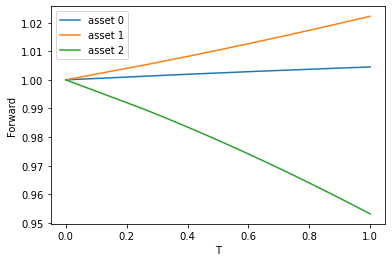

In [13]:
ts=np.linspace(0,1,201)
for i in range(nassets):
    plt.plot(ts,fwds[i](ts),label=f"asset {i}")
plt.legend()
plt.xlabel("T")
plt.ylabel("Forward")

### Problem 1.2: 


Make a plot of the *At the money forward* volatilities for the three assets.

[HINT] The ATM volatility for a expiry $T$ is the implied volatility at strike $K=F_t$:

$$
    \sigma_\text{ATM}(T) = \sigma_I(T,F_t)
$$

Text(0, 0.5, '$\\sigma_{ATM}$')

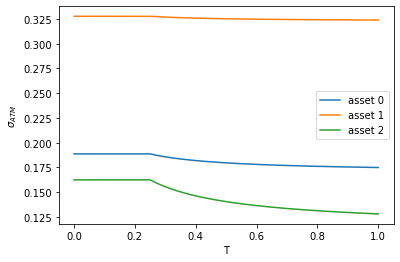

In [14]:
ts=np.linspace(0,1,201)
for i in range(nassets):
    plt.plot(ts,vols[i](ts,fwds[i](ts)),label=f"asset {i}")
plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\sigma_{ATM}$") 

### Problem 1.3

Plot the implied volatility for all asset at the one year expiry and  for strikes in range $K\in [0.5,2]$

Text(0, 0.5, '$\\sigma_I(1,K)$')

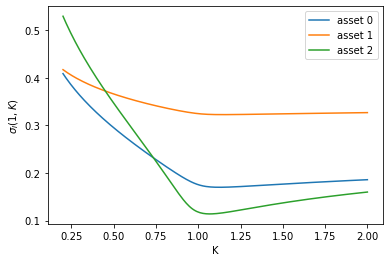

In [15]:
T=1
Ks=np.linspace(0.2,2,201)
for i in range(nassets):
    plt.plot(Ks,vols[i](T,Ks),label=f"asset {i}")
plt.legend()
plt.xlabel("K")
plt.ylabel(r"$\sigma_I(1,K)$") 

### Problem 1.4 

Plot the local volatility  for all asset at the one year expiry and  for strikes in range $K\in [0.5,2]$

Text(0, 0.5, '$\\sigma(1,K)$')

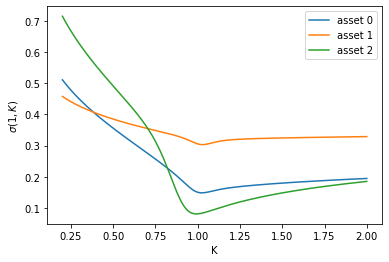

In [16]:
for i in range(nassets):
    F=fwds[i](T)
    plt.plot(Ks,vols[i].local_vol(T,Ks,F),label=f"asset {i}")
plt.legend()
plt.xlabel("K")
plt.ylabel(r"$\sigma(1,K)$") 

## Problem 2: Monte Carlo Paths

### Problem 2.1 

Using the market data inputs ([forwards, volatilities and correlations](#market-data)) defined previously in this notebook use Monte Carlo with the [Multivariate Local volatility process](#vol_process) to generate 10,000 paths  with daily time steps for one year.

In [17]:
process=MVLocalVolProcess(fwds,vols,corr)
process

In [18]:
npaths=10_000

In [19]:
mc_ts=np.linspace(0,1,366)

In [20]:
S0=np.array([1,1,1])
nvars=len(S0)
nvars

3

In [21]:
paths=propagate(process,S0,mc_ts,rng,npaths)

### Problem 2.2 

What is the shape of the Monte Carlo Path array? what dimensions correspond to time step, asset and path sample?

In [22]:
paths.shape

(366, 3, 10000)

<div class="alert alert-block alert-success"> 

1. First dimension is time step
2. Second Dimension is asset
3. Third dimension is path sample

</div>

### Problem 2.3 

Compute the MC sampled forwards for each one of the assets at for each time step

[HINT] You just need to compute the average over the paths dimension of the array:
$$
    F_{\alpha,T} = \frac{1}{\text{npaths}} \sum_{p=1}^\text{npaths} S_{\alpha,T}
$$

In [23]:
mc_fwd=paths.mean(axis=-1)
mc_fwd.shape

(366, 3)

### Problem 2.4 

Compute the MC estimated standard deviation of forwards for each one of the assets at for each time step


[HINT] The MC standard deviation is given by

$$
    \delta F_{\alpha,T} = \sqrt{ \frac{\text{Var}(S_{\alpha,T})}{\text{npaths}}}
$$

In [24]:
mc_std=np.sqrt(paths.var(axis=-1)/npaths)
mc_std.shape

(366, 3)

### Problem 2.5 

Make a plot comparing the market forwards (as defined in [notebook inputs](#market-data)) to the Monte Carlo sampled forwards.

Share an area of $\pm 2$ standard deviations around the MC forward.

[HINT] Use [matplotlib.fill_between](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) function to plot the shaded area

Text(0, 0.5, 'Forward')

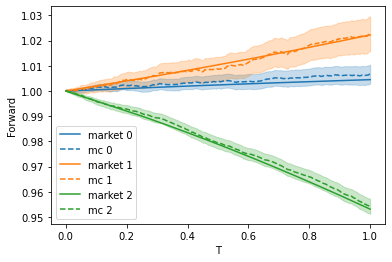

In [25]:
ts=np.linspace(0,1,201)
for i in range(nassets):
    p=plt.plot(ts,fwds[i](ts),label=f"market {i}")
    color=p[0].get_color()
    plt.plot(mc_ts,mc_fwd[:,i],linestyle="dashed",color=color,label=f"mc {i}")
    plt.fill_between(mc_ts,mc_fwd[:,i]-2*mc_std[:,i],mc_fwd[:,i]+2*mc_std[:,i],color=color,alpha=0.25)
plt.legend()
plt.xlabel("T")
plt.ylabel("Forward")



### Problem 2.6 </div>

#### At The Money Forward Volatilities

For every asset $i=1,2,3$ and every time step $t_k$ for $k=1,\dots,${365}$ compute the MC estimated  value of **at the money forward call option** with expiry $T=t_k$, and strike $K=F_{T}$, an its standard deviation.

[HINTS]  
1. Skip $t_0=0$ expiry (there is no optionality if the expiry is $T=0$).
2. You should end up with a $365 \times 3$ array of option values and a similar array of the standard deviation.
3. Do not fell like you have  to do anything too fancy numpy calculations. An implementation suing two  nested python loops for $i$ and $t_k$ is fine.

In [26]:
opts=np.zeros((len(mc_ts)-1,nassets)) # 366, first empty will be zero
dopts=np.zeros((len(mc_ts)-1,nassets))
is_call= True
for i in range(nassets):
    for idx,T,in enumerate(mc_ts[1:]):
        payout=EuropeanOptionPayoff(is_call,mc_fwd[idx+1,i],T,index=i)
        payout.set_steps(mc_ts)
        val=payout(paths)
        opts[idx,i]=np.mean(val)
        dopts[idx,i]=np.sqrt(np.var(val)/npaths) 
opts.shape,dopts.shape

((365, 3), (365, 3))

### Problem 2.7 

For every asset $i=1,2,3$ and every time step $t_k$ for $k=1,\dots,365$ compute the **market price** of the same ATM call options of Problem 2.6   using 
Black-Scholes and the [market inputs](#market-data).  
    
    
[HINTS]  
1. Skip again $t_0=0$ expiry (there is no optionality if the expiry is $T=0$).
2. You should end up with a $365 \times 3$ array of market option values.
3. Do not fell like you have  to do anything too fancy numpy calculations. An implementation suing two  nested python loops for $i$ and $t_k$ is fine.
4. For any asset $i=1,2,3$ and any expiry $T=t_k$, you need first to compute the market forward $F_T$, and the ATM volatility $\sigma_I(T,F_T)$ before you can apply Black-Scholes.

In [27]:
market_fwds=np.empty((len(mc_ts),nassets))
for i in range(nassets):
    market_fwds[:,i]=fwds[i](mc_ts)
market_fwds.shape

(366, 3)

In [28]:
market_vols=np.empty((len(mc_ts),nassets))
for i in range(nassets):
    market_vols[:,i]=vols[i](mc_ts,market_fwds[:,i])
market_vols.shape

(366, 3)

In [29]:
market_prices=bs_price_fwd(True,market_fwds[1:],mc_ts[1:,np.newaxis],market_fwds[1:],market_vols[1:])
market_prices.shape

(365, 3)

Text(0, 0.5, 'Option Price')

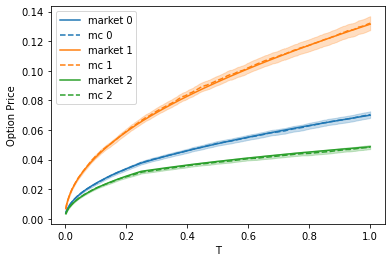

In [30]:
for i in range(nassets):
    p=plt.plot(mc_ts[1:],market_prices[:,i],label=f"market {i}")
    color=p[0].get_color()
    plt.plot(mc_ts[1:],opts[:,i],linestyle="dashed",color=color,label=f"mc {i}")
    plt.fill_between(mc_ts[1:],opts[:,i]-2*dopts[:,i],opts[:,i]+2*dopts[:,i],color=color,alpha=0.25)
plt.legend()
plt.xlabel("T")
plt.ylabel("Option Price")

### Problem 2.8 

For every asset $i=1,2,3$ and every time step $t_k$ for $k=1,\dots,365$ compute the **implied volatility** of the montecarlo estimated prices and compare it to the market implied probabilities.
    
    
[HINTS]  Use [bs_implied_fwd](#implied-vol) to convert the Monte Carlo prices into implied volatilities.


In [31]:
ivols=np.empty((len(mc_ts)-1,nassets))
ivols0=np.empty((len(mc_ts)-1,nassets))
ivols1=np.empty((len(mc_ts)-1,nassets))
for i in range(nassets):
    for idx,T in enumerate(mc_ts[1:]):
        F=mc_fwd[idx,i]
        p=opts[idx,i]
        dp=dopts[idx,i]
        ivols[idx,i]=bs_implied_fwd(True,F,T,F,p)
        ivols0[idx,i]=bs_implied_fwd(True,F,T,F,np.maximum(p-2*dp,epsilon))
        ivols1[idx,i]=bs_implied_fwd(True,F,T,F,p+2*dp)

Text(0, 0.5, 'Implied Volatility')

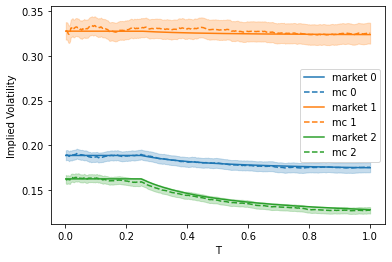

In [32]:
for i in range(nassets):
    p=plt.plot(mc_ts[1:],market_vols[1:,i],label=f"market {i}")
    color=p[0].get_color()
    plt.plot(mc_ts[1:],ivols[:,i],linestyle="dashed",color=color,label=f"mc {i}")
    plt.fill_between(mc_ts[1:],ivols0[:,i],ivols1[:,i],color=color,alpha=0.25)
plt.legend()
plt.xlabel("T")
plt.ylabel("Implied Volatility")

### Problem 2.8:  Volatility Skew



For every asset $i=1,2,3$ and evently spaced strikes $K$ between 0.75 and 1.5 compute the MC estimated  value of  call option one year expiry $T=1$, an its standard deviation.


In [33]:
T=1
Ks=np.linspace(0.75,1.5,201)
opts=np.zeros((len(Ks),nassets)) # 366, first empty will be zero
dopts=np.zeros((len(Ks),nassets))
is_call= True
for i in range(nassets):
    for idx,K,in enumerate(Ks):
        payout=EuropeanOptionPayoff(is_call,K,T,index=i)
        payout.set_steps(mc_ts)
        val=payout(paths)
        opts[idx,i]=np.mean(val)
        dopts[idx,i]=np.sqrt(np.var(val)/npaths) 
opts.shape,dopts.shape

((201, 3), (201, 3))

### Problem 2.10

For every asset $i=1,2,3$ and evently spaced strikes $K$ between 0.75 and 1.5 compute the **market price** of the same call option one year expiry $T=1$ using 
Black-Scholes and the [market inputs](#market-data). 
    
    

In [34]:
market_vols=np.empty((len(Ks),nassets))
for i in range(nassets):
    market_vols[:,i]=vols[i](T,Ks)
market_vols.shape

(201, 3)

In [35]:
Fs=np.empty(nassets)
for i in range(nassets):
    Fs[i]=fwds[i](T)

In [36]:
market_prices=bs_price_fwd(True,Ks[:,np.newaxis],T,Fs[np.newaxis,:],market_vols)
market_prices.shape

(201, 3)

Text(0, 0.5, 'Option Price')

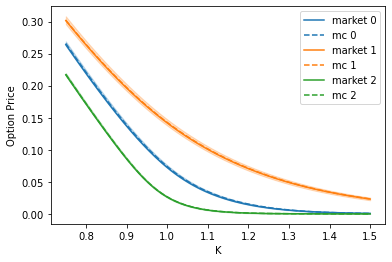

In [37]:
for i in range(nassets):
    p=plt.plot(Ks,market_prices[:,i],label=f"market {i}")
    color=p[0].get_color()
    plt.plot(Ks,opts[:,i],linestyle="dashed",color=color,label=f"mc {i}")
    plt.fill_between(Ks,opts[:,i]-2*dopts[:,i],opts[:,i]+2*dopts[:,i],color=color,alpha=0.25)
plt.legend()
plt.xlabel("K")
plt.ylabel("Option Price")

### Problem 2.11

For every asset  𝑖=1,2,3  and evently spaced strikes  𝐾  between 0.75 and 1.5 compute **implied volatility** of the Monte Carlo prices of the same call option with one year expiry  𝑇=1.  
    
[HINTS]  Use [bs_implied_fwd](#implied-vol) to convert the Monte Carlo prices into implied volatilities.


In [38]:
ivols=np.empty((len(Ks),nassets))
ivols0=np.empty((len(Ks),nassets))
ivols1=np.empty((len(Ks),nassets))
for i in range(nassets):
    for idx,K in enumerate(Ks):
        F=Fs[i]
        p=opts[idx,i]
        dp=dopts[idx,i]
        ivols[idx,i]=bs_implied_fwd(True,K,T,F,p)
        ivols1[idx,i]=bs_implied_fwd(True,K,T,F,p+2*dp)
        intrinsic=np.maximum(F-K,0.0)+epsilon
        ivols0[idx,i]=bs_implied_fwd(True,K,T,F,np.maximum(p-2*dp,intrinsic),tol=epsilon)
        
       

Text(0, 0.5, 'Implied Volatility')

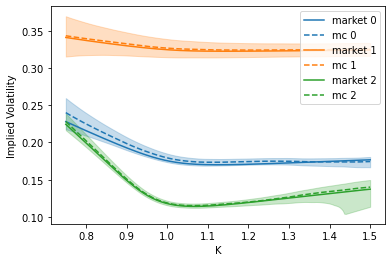

In [39]:
for i in range(nassets):
    p=plt.plot(Ks,market_vols[:,i],label=f"market {i}")
    color=p[0].get_color()
    plt.plot(Ks,ivols[:,i],linestyle="dashed",color=color,label=f"mc {i}")
    plt.fill_between(Ks,ivols0[:,i],ivols1[:,i],color=color,alpha=0.25)
plt.legend(loc="upper right")
plt.xlabel("K")
plt.ylabel("Implied Volatility")

## Problem 3: Call on the Worst Asian Average

### Problem 3.1 

Fill in the payoff class payoff below to implement a **call option on the worst of the Asian averages** of the assets:

\begin{align*}
  A_\alpha &= \frac{1}{N} \sum_{t < T}^{T} S_{\alpha,t} \\
    W &= \min_\alpha A_\alpha \\
    \text{payoff} &= \max(0, W - K)
\end{align*}

where $N$ is the number of observations lest of equal to the expiry $T$

In [40]:
class CallWorstofAsiansPayoff:
    def __init__(self,strike,expiry):
        pass
    def set_steps(self,ts):
        pass
    def __call__(self,paths):
        pass

In [41]:
class CallWorstofAsiansPayoff:
    def __init__(self,strike,expiry):
        self.strike=strike
        self.expiry=expiry
        self.step=None
    def set_steps(self,ts):
        self.step=np.searchsorted(ts,self.expiry)
    def __call__(self,paths):
        s=paths[:self.step] # restict observation up to expiry
        m=s.mean(axis=0) # compute Asian mean for each asset
        w=m.min(axis=0) # compute work of means
        val=np.maximum(0.0,w-self.strike) # call on worst of means      
        return val

### Problem 3.2

Use the `CallWorstofAsiansPayoff` and MC paths we generated previously to price call options on the worst of the Asian averages with strike $K=1$ and expiries $T=\frac{1}{4},\frac{1}{2}$,and $1$.

Make sure to estimate also the MC estimate standard deviation.

In [42]:
for T in [0.25,0.5,1]:
    payoff=CallWorstofAsiansPayoff(1,T)
    payoff.set_steps(mc_ts)
    values=payoff(paths)
    opt=values.mean()
    dopt=np.sqrt(values.var()/npaths)
    print(T,opt,dopt)

0.25 0.006622247326091324 0.00014932116835664083
0.5 0.008581717182439825 0.0001955337284369659
1 0.009674091277298845 0.00023886925724571708


### Problem 3.3: Call on Asian average of the  worst asset



Fill in the payoff class payoff below to implement a **call option on the Asian average of worst of the three assets**:

\begin{align*}
    W_t &= \min_\alpha S_{\alpha,t} \\
    A &= \frac{1}{N} \sum_{t < T}^{T} M_{t} \\
    \text{payoff} &= \max(0, A - K)
\end{align*}

where $N$ is the number of observations lest of equal to the expiry $T$

In [43]:
class CallAsianofWorstPayoff:
    def __init__(self,strike,expiry):
        pass
    def set_steps(self,ts):
        pass
    def __call__(self,paths):
        pass

In [44]:
class CallAsianofWorstPayoff:
    def __init__(self,strike,expiry):
        self.strike=strike
        self.expiry=expiry
        self.step=None
    def set_steps(self,ts):
        self.step=np.searchsorted(ts,self.expiry)
    def __call__(self,paths):
        s=paths[:self.step] # restict observation up to expiry
        w=s.min(axis=1) # compute worst performing asset on each time step
        m=w.mean(axis=0) # compute asian mean of wort of assets
        val=np.maximum(0.0,m-self.strike) # call on the work of means
        return val

### Problem 3.4 

Use the `CallAsianofWorstPayoff` and MC paths we generate previous to price call options on the Asian average of the  worst of the assets with strike $K=1$ and expiries $T=\frac{1}{4},\frac{1}{2}$,and $1$.

Make sure to estimate also the MC estimate standard deviation.

In [45]:
for T in [0.25,0.5,1]:
    payoff=CallAsianofWorstPayoff(1,T)
    payoff.set_steps(mc_ts)
    values=payoff(paths)
    opt=values.mean()
    dopt=np.sqrt(values.var()/npaths)
    print(T,opt,dopt)

0.25 0.005022514996659015 0.00012863709524671389
0.5 0.006437118424523874 0.00016879546936764142
1 0.007070930482686338 0.00020367069106230643


### Problem 3.5 

With one is a cheaper option, the Worst of Asians or the Asian of the Worst ?

Can you explain why?

<div class="alert alert-block alert-success"> 

The call on the Asian average of the worst asset is cheaper than the call on the Worst of the Asian averages.

The Asian on the worst asset will always be lower than either of the three assets Asians,
because at each time the worst asset is lower than each one of them. 

$$
    W_t  \le S_{\alpha,t} \ \ \ \text{for}\ \  \alpha=1,2,3
$$    
therefore 
$$
    M = \frac{1}{N} \sum_{t<T}^T W_t \le  \frac{1}{N} \sum_{t<T}^T S_{\alpha,t} = A_\alpha \ \ \ \text{for}\ \  \alpha=1,2,3
$$
and, thus

$$
    M \le \min_\alpha A_\alpha = W.
$$
  
Now, because $M\le W$ a call on $M$ will aways be less than a call on $W$ with the same strike.

</div>